# Student Loan Risk with Deep Learning

In [178]:
# Imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, Nadam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from pathlib import Path

import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


---

## Part 1: Prepare the data to be used on a neural network model

### Step 1: Read the `student-loans.csv` file into a Pandas DataFrame. Review the DataFrame, looking for columns that could eventually define your features and target variables.   

In [179]:
# Read the csv into a Pandas DataFrame
file_path = "https://static.bc-edx.com/ai/ail-v-1-0/m18/lms/datasets/student-loans.csv"
loans_df = pd.read_csv(file_path)

# Review the DataFrame
display (loans_df.head())
display (loans_df.shape)

,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score,credit_ranking
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


(1599, 12)

In [180]:
# Review the data types associated with the columns
loans_df.dtypes

payment_history           float64
location_parameter        float64
stem_degree_score         float64
gpa_ranking               float64
alumni_success            float64
study_major_code          float64
time_to_completion        float64
finance_workshop_score    float64
cohort_ranking            float64
total_loan_score          float64
financial_aid_score       float64
credit_ranking              int64
dtype: object

In [181]:
# Check the credit_ranking value counts
display (loans_df["credit_ranking"].value_counts())
# another way of looking at the feature. not prefered as this does not show the count per class
display (loans_df['credit_ranking'].unique())

credit_ranking
1    855
0    744
Name: count, dtype: int64

array([0, 1], dtype=int64)

### Step 2: Using the preprocessed data, create the features (`X`) and target (`y`) datasets. The target dataset should be defined by the preprocessed DataFrame column “credit_ranking”. The remaining columns should define the features dataset.

In [182]:
# Define the target set y using the credit_ranking column

y = loans_df['credit_ranking']
# Display a sample of y

np.array(y)[:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [183]:
# Define features set X by selecting all columns but credit_ranking
X=loans_df.drop(columns=['credit_ranking'])

# Review the features DataFrame
display (X.head())


,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Step 3: Split the features and target sets into training and testing datasets.


# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=1)

In [184]:
# Assume X and y are your features and labels respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)  # Split into training and temp (validation + test)

### Step 4: Use scikit-learn's `StandardScaler` to scale the features data.

In [185]:
# Step 1: Create a StandardScaler instance
scaler = StandardScaler()

# Step 2: Fit the scaler to the features training dataset
scaler.fit(X_train)

# Step 3: Transform the features training dataset
X_train_scaled = scaler.transform(X_train)

# Step 4: Transform the features testing dataset
X_test_scaled = scaler.transform(X_test)

---

## Part 2 Compile and Evaluate a Model Using a Neural Network

### Step 1: Create a deep neural network by assigning the number of input features, the number of layers, and the number of neurons on each layer using Tensorflow’s Keras.

> **Hint** You can start with a two-layer deep neural network model that uses the `relu` activation function for both layers.


In [186]:
# Define the the number of inputs (features) to the model
input_nodes  = X_train_scaled.shape[1]
# or 
# input_nodes = len(X.columns)

# Review the number of features
display ("Number of input features:", input_nodes )

'Number of input features:'

11

# Neural Network Configuration Guide

## 1. Define the Number of Hidden Nodes for the First Hidden Layer
For the first hidden layer, a common approach is to start with a number of nodes that is somewhere between the number of input features and the number of output neurons. A typical strategy might be to use a number of nodes that is the mean or the geometric mean of these two numbers, adjusted based on the complexity of the problem or empirical testing.

## 2. Define the Number of Hidden Nodes for the Second Hidden Layer
For the second hidden layer, you might choose to reduce the number of nodes compared to the first hidden layer. This is often done to gradually reduce the dimensionality and to aggregate the features extracted by the first layer. A typical rule might be to halve the number of nodes in each subsequent layer, although the specific number should be tuned based on model performance and overfitting concerns.

## 3. Define the Number of Neurons in the Output Layer
The number of neurons in the output layer depends on the type of problem:

- **Binary Classification**: Use 1 neuron with a sigmoid activation function.
- **Multiclass Classification**: Use as many neurons as there are classes, with a softmax activation function.
- **Regression**: Typically use 1 neuron for a single output; for multiple outputs, use as many neurons as there are outputs.


In [187]:
# Define the number of hidden nodes for the first hidden layer
num_nodes_first_hidden_layer = (input_nodes + 1) // 2  # Example calculation

# Define the number of hidden nodes for the second hidden layer
num_nodes_second_hidden_layer = num_nodes_first_hidden_layer // 2

# For binary classification
num_output_neurons = 1  # Using sigmoid activation
# For multiclass classification (e.g., 3 classes)  num_output_neurons = 3  # Using softmax activation
# For regression num_output_neurons = 1  # Typically with no activation (or linear activation)


display (f'Number of hidden nodes for the first hidden layer  : {num_nodes_first_hidden_layer}')
display (f'Number of hidden nodes for the second hidden layer : {num_nodes_second_hidden_layer}')
display (f'Number of neurons in the output layer              : {num_output_neurons}')


'Number of hidden nodes for the first hidden layer  : 6'

'Number of hidden nodes for the second hidden layer : 3'

'Number of neurons in the output layer              : 1'

# Create the Sequential model instance
model = Sequential()

# Add the first hidden layer
model.add(Dense(units=num_nodes_first_hidden_layer, activation='relu', input_dim=input_nodes))

# Add the second hidden layer
model.add(Dense(units=num_nodes_second_hidden_layer, activation='relu'))

# Add the output layer to the model specifying the number of output neurons and activation function
model.add(Dense(num_output_neurons, activation='sigmoid'))

In [188]:
# Create the Sequential model instance
model = Sequential(name='Student_Loan_Model')

# Add the first hidden layer with input dimension specified
model.add(Dense(units=num_nodes_first_hidden_layer, activation='relu', input_dim=input_nodes, name='First_Hidden_Layer'))
# model.add(BatchNormalization(name='BatchNorm_Layer_1'))  # Normalize the activations from the first hidden layer
# model.add(Dropout(0.7, name='Dropout_Layer_1'))  # Dropout for regularization to prevent overfitting

# Add the second hidden layer
model.add(Dense(units=num_nodes_second_hidden_layer, activation='relu', name='Second_Hidden_Layer'))
# model.add(BatchNormalization(name='BatchNorm_Layer_2'))  # Normalize the activations from the second hidden layer
# model.add(Dropout(0.7, name='Dropout_Layer_2'))  # Additional dropout layer for regularization

# Add the output layer
# If this is a binary classification problem, use 'sigmoid'. If it's regression, no activation or 'linear' can be used.
model.add(Dense(num_output_neurons, activation='sigmoid', name='Output_Layer'))  # Use 'linear' if it's a regression task


In [189]:
# Display the Sequential model summary
display (model.summary())

Model: "Student_Loan_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Hidden_Layer (Dense)  (None, 6)                 72        
                                                                 
 Second_Hidden_Layer (Dense)  (None, 3)                21        
                                                                 
 Output_Layer (Dense)        (None, 1)                 4         
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


None

### Step 2: Compile and fit the model using the `binary_crossentropy` loss function, the `adam` optimizer, and the `accuracy` evaluation metric.


In [190]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [191]:
# Compile the Sequential model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [192]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [193]:
# Fit the model using 50 epochs and the training data
fit_model = model.fit(X_train_scaled, y_train, 
                      epochs=150, 
                      batch_size=150,
                      # class_weight=class_weight_dict, 
                      validation_split=(0.2),
                      callbacks=[early_stopping])
                   


Epoch 1/150
7/7 [==============================] - 1s 34ms/step - loss: 0.6865 - accuracy: 0.6051 - val_loss: 0.6839 - val_accuracy: 0.6133
Epoch 2/150
7/7 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.6178 - val_loss: 0.6827 - val_accuracy: 0.6289
Epoch 3/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6833 - accuracy: 0.6256 - val_loss: 0.6814 - val_accuracy: 0.6367
Epoch 4/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.6373 - val_loss: 0.6801 - val_accuracy: 0.6406
Epoch 5/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6801 - accuracy: 0.6364 - val_loss: 0.6787 - val_accuracy: 0.6445
Epoch 6/150
7/7 [==============================] - 0s 10ms/step - loss: 0.6782 - accuracy: 0.6403 - val_loss: 0.6774 - val_accuracy: 0.6406
Epoch 7/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6762 - accuracy: 0.6481 - val_loss: 0.6761 - val_accuracy: 0.6445
Epoch 8/150
7/7 [========

### Step 3: Evaluate the model using the test data to determine the model’s loss and accuracy.


In [194]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

# Display the model loss and accuracy results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4%}")

Test Loss: 0.5245
Test Accuracy: 74.6875%


{'loss': [0.6864959001541138, 0.6848676800727844, 0.6832515597343445, 0.6816886067390442, 0.680065393447876, 0.6781668066978455, 0.6762340664863586, 0.674435555934906, 0.6724426746368408, 0.6705082058906555, 0.6682818531990051, 0.6660747528076172, 0.6638701558113098, 0.6616989970207214, 0.6593522429466248, 0.6569123864173889, 0.6544843316078186, 0.6520752310752869, 0.649249792098999, 0.6461945176124573, 0.6432160139083862, 0.6399233341217041, 0.6365868449211121, 0.6328328251838684, 0.6291282773017883, 0.625190794467926, 0.6209637522697449, 0.6163829565048218, 0.611964762210846, 0.6069644689559937, 0.601994514465332, 0.5969362854957581, 0.5920389294624329, 0.5870833396911621, 0.5820267200469971, 0.5770381093025208, 0.5723134279251099, 0.5676057934761047, 0.5631141662597656, 0.5589017271995544, 0.5549337267875671, 0.5514207482337952, 0.5479975938796997, 0.5446577668190002, 0.5418633818626404, 0.5389493703842163, 0.5364855527877808, 0.5342528223991394, 0.5322376489639282, 0.53037071228027

<Axes: >

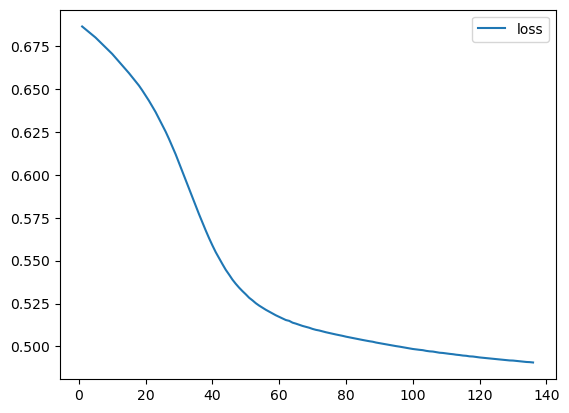

In [195]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)
print (fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")


### Step 4: Save and export your model to a keras file, and name the file `student_loans.keras`.


In [197]:
# Set the model's file path
file_path = Path("./resources/student_loans.keras")

# Export your model to a keras file
model.save(file_path)

---
## Predict Loan Repayment Success by Using your Neural Network Model

### Step 1: Reload your saved model.

In [198]:
# Set the model's file path
file_path = Path("./resources/student_loans.keras")

# Load the model to a new object
lr_model = load_model(file_path)

### Step 2: Make predictions on the testing data and save the predictions to a DataFrame.

In [199]:
# Make predictions with the test data
predictions = lr_model.predict(X_test_scaled,verbose=0)


# Display a sample of the predictions
print (predictions[:5])

[[0.56772184]
 [0.29440048]
 [0.77438086]
 [0.7342451 ]
 [0.9605413 ]]


In [200]:
# Save the predictions to a DataFrame and round the predictions to binary results
predictions_df = pd.DataFrame(data=predictions, columns=['Predicted_Probability'])
# Round predictions to binary results (0 or 1) using 0.5 as the threshold
predictions_df['Predicted_Class'] = np.where(predictions_df['Predicted_Probability'] >= 0.5, 1, 0)
predictions_df.head(5)

,Predicted_Probability,Predicted_Class
0,0.567722,1
1,0.294400,0
2,0.774381,1
3,0.734245,1
4,0.960541,1


### Step 4: Display a classification report with the y test data and predictions

In [201]:
# Print the classification report with the y test data and predictions
print("\nClassification Report:")
print(classification_report(y_test, predictions_df['Predicted_Class'].values))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       154
           1       0.76      0.74      0.75       166

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



### 1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.

To build a recommendation system for student loan options, you would need to collect the following data:

1. **Student Information:**
   - **Demographics:** Age, gender, location, etc.
   - **Academic Information:** Current school, major, GPA, year of study.
   - **Financial Background:** Income level, employment status, credit score (if applicable), financial aid received.

2. **Loan Details:**
   - **Loan Types:** Federal loans, private loans, subsidized loans, unsubsidized loans.
   - **Interest Rates:** Fixed vs. variable rates, APRs.
   - **Loan Terms:** Duration of the loan, repayment plans, grace periods.
   - **Eligibility Criteria:** Credit score requirements, co-signer requirements, income thresholds.

3. **Historical Data:**
   - **Previous Loan Data:** Past loans taken by students, repayment histories.
   - **Default Rates:** Statistics on default rates for different loan types and lenders.
   - **Success Stories:** Case studies or testimonials from students who have successfully repaid their loans.

4. **External Factors:**
   - **Economic Indicators:** Unemployment rates, inflation rates, average starting salaries for various fields.
   - **Legislation:** Current student loan policies, upcoming changes in legislation.

#### Relevance and Appropriateness:
- **Student Information:** Helps tailor recommendations to individual needs and circumstances.
- **Loan Details:** Essential for matching students with the most suitable loan options based on their financial situation.
- **Historical Data:** Provides insights into the performance and reliability of different loan types and lenders.
- **External Factors:** Ensures that recommendations are realistic and take into account the current economic environment.

### 2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.

Based on the data collected, a **content-based filtering** approach would be most suitable for this recommendation system.

#### Justification:
- **Content-based filtering** relies on the attributes of both users (students) and items (loans) to make recommendations. Given the extensive data on student demographics, academic information, financial background, and detailed loan characteristics, content-based filtering can effectively match students with loan options that best meet their specific needs.
- **Collaborative filtering** is less suitable here because it relies on user interactions and similarities between users, which might be sparse in the context of student loans, as not all students will have extensive borrowing histories or relevant interactions.
- **Context-based filtering** could be a secondary method, incorporating external factors like economic indicators and legislation changes to refine recommendations further. However, the primary matching will still be content-based due to the detailed user and item attributes available.

### 3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.

#### 1. Data Privacy and Security:
- **Challenge:** Handling sensitive personal and financial information of students requires strict adherence to data privacy laws and regulations (e.g., GDPR, FERPA).
- **Concern:** Any breach of this data could lead to severe consequences for students, including identity theft and financial loss. Ensuring robust data encryption, secure storage, and compliance with privacy laws is critical to maintaining trust and legal compliance.

#### 2. Bias and Fairness:
- **Challenge:** Ensuring that the recommendation system does not inadvertently favor or disadvantage certain groups of students based on their demographics, background, or other attributes.
- **Concern:** If the system shows bias, it could result in unequal access to loan options, further exacerbating existing inequalities. For example, if the system favors students with higher credit scores disproportionately, it might not provide adequate options for students from lower-income backgrounds who may have lower credit scores but still need financial assistance for their education. Ensuring fairness in recommendations is crucial to support all students equitably.

#### Additional Considerations:
- **Regulatory Compliance:** Ensuring that the recommendation system complies with all relevant laws and regulations regarding student loans and financial advice.
- **Economic Volatility:** Accounting for economic changes that might affect loan terms and repayment capacities, ensuring that recommendations remain relevant and realistic over time.

By addressing these challenges, the recommendation system can provide reliable, fair, and secure loan options to students, helping them make informed financial decisions for their education.

## Credits

This project was developed with the assistance and resources provided by OpenAI's GPT-4. The use of OpenAI's technology facilitated the creation of a robust recommendation system and comprehensive documentation.

### Acknowledgements

- **OpenAI:** For providing the powerful language model, GPT-4, which was instrumental in generating insights, structuring the recommendation system, and drafting detailed explanations and code.
- **Developers and Researchers at OpenAI:** For their continuous efforts in advancing artificial intelligence and natural language processing, making tools like GPT-4 accessible for educational and professional projects.

### Tools and Libraries

- **Python:** Used for coding and implementing the recommendation system.
- **Pandas and NumPy:** For data manipulation and analysis.
- **Scikit-Learn:** For machine learning algorithms and evaluation metrics.
- **Keras:** For building and training the neural network models.

### Contact Information

For any questions or further information about this project, please contact:

- **Project Author:** [Your Name]
- **Email:** [Your Email]

### Disclaimer

This project is for educational purposes and does not constitute financial advice. The recommendations generated by this system are based on the data and methods described and should be used as a guide only. Always consult a financial advisor before making any significant financial decisions.

---

Thank you for reviewing this project!
